# Projecting microcolumn data on the Tasic 2018 dataset

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time

# import tsne
import sys; sys.path.append('../FIt-SNE')
from fast_tsne import fast_tsne

# import my feature selection function
import rnaseqTools

In [ ]:
# THIS CELL IS COPY-PASTED FROM THE ART OF TSNE DEMO NOTEBOOK
# See there for where to get the raw data
# https://github.com/berenslab/rna-seq-tsne/

def sparseload(filenames):
    genes = []
    sparseblocks = []
    areas = []
    cells = []
    for chunk1,chunk2 in zip(pd.read_csv(filenames[0], chunksize=1000, index_col=0, na_filter=False),
                             pd.read_csv(filenames[1], chunksize=1000, index_col=0, na_filter=False)):
        if len(cells)==0:
            cells = np.concatenate((chunk1.columns, chunk2.columns))
            areas = [0]*chunk1.columns.size + [1]*chunk2.columns.size
        
        assert(np.all(chunk1.index==chunk2.index))
        genes.extend(list(chunk1.index))
        sparseblock1 = sparse.csr_matrix(chunk1.values.astype(float))
        sparseblock2 = sparse.csr_matrix(chunk2.values.astype(float))
        sparseblock = sparse.hstack((sparseblock1,sparseblock2), format='csr')
        sparseblocks.append([sparseblock])
        print('.', end='', flush=True)
    print(' done')
    counts = sparse.bmat(sparseblocks)
    return (counts.T, np.array(genes), cells, np.array(areas))

filenames = ['../data/tasic-nature/mouse_VISp_2018-06-14_exon-matrix.csv',
             '../data/tasic-nature/mouse_ALM_2018-06-14_exon-matrix.csv']
counts, genes, cells, areas = sparseload(filenames)

genesDF = pd.read_csv('../data/tasic-nature/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('../data/tasic-nature/sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids) - 1

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

impGenes = rnaseqTools.geneSelection(counts, threshold=32, n=3000, decay=1.5, plot=False)
seqDepths = np.array(counts.sum(axis=1))

tasic2018reduced = {'counts': counts[:,impGenes],
                    'genes' : genes[impGenes],
                    'areas': areas, 
                    'clusters': clusters,
                    'clusterColors': clusterColors,
                    'clusterNames': clusterNames,
                    'seqDepths': seqDepths}

pickle.dump(tasic2018reduced, open('tasic2018.pickle', 'wb'))

In [3]:
tasic2018 = pickle.load(open('../mini-atlas/reduced-allen-data/tasic2018.pickle', 'rb'))

In [6]:
%%time

X = np.log2(tasic2018['counts'] / tasic2018['seqDepths'] * 1e+6 + 1)  
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

PCAinit = X[:,:2]/np.std(X[:,0])*.0001
Z = fast_tsne(X, perplexity_list = [30,int(X.shape[0]/100)], 
              initialization = PCAinit, learning_rate=X.shape[0]/12)

CPU times: user 1min 24s, sys: 2.44 s, total: 1min 26s
Wall time: 2min 27s


In [7]:
# Export for Cathryn

d = {'tSNE1': Z[:,0], 'tSNE2': Z[:,1], 
     'clusterNum': tasic2018['clusters'], 
     'clusterName': tasic2018['clusterNames'][tasic2018['clusters']],
     'clusterColor': tasic2018['clusterColors'][tasic2018['clusters']]}
df = pd.DataFrame(d)
df = df[['tSNE1', 'tSNE2', 'clusterNum', 'clusterName', 'clusterColor']]
df.to_csv('export/allen-tsne.txt', header=None, index=None, sep='\t')
df

,tSNE1,tSNE2,clusterNum,clusterName,clusterColor
0,44.063001,33.326673,93,L5 PT ALM Slco2a1,#53D385
1,53.478567,-28.172711,72,L5 IT ALM Npw,#33A9CE
2,-35.949497,7.183766,1,Lamp5 Fam19a1 Pax6,#FF88AD
3,-43.347397,13.079521,7,Sncg Slc17a8,#9440F3
4,-44.062858,13.363719,7,Sncg Slc17a8,#9440F3
5,-42.396845,11.625861,7,Sncg Slc17a8,#9440F3
6,-35.170034,10.663272,0,Lamp5 Krt73,#DDACC9
7,-45.045213,13.002436,10,Sncg Vip Itih5,#6C00BF
8,53.140993,-28.553685,73,L5 IT ALM Pld5,#0094C2
9,57.814732,-42.764086,65,L2/3 IT ALM Macc1 Lrg1,#ADE6A6


## Load microcolumn counts

In [9]:
# Load preprocessed data from Cathryn

pp = pd.read_csv('data/sceNormalizedCountsKeepGenes-1.tsv', sep='\t')
pp_cells = np.array(pp.columns)
pp_reads = pp.values.T
pp_genes = np.array(pp.index)

pp = pd.read_csv('data/sceNormalizedCountsAnnotations.tsv', sep='\t')
layers = pp['layer'].values
regions = pp['region'].values

microcolumns = {'counts':pp_reads, 'cells':pp_cells, 'genes':pp_genes, 'layers':layers, 'regions':regions}
print(microcolumns['counts'].shape)

(206, 12841)


## Project onto tSNE

In [12]:
pos, pos_boot = rnaseqTools.map_to_tsne(tasic2018['counts'], tasic2018['genes'],
                              microcolumns['counts'], microcolumns['genes'], Z,
                              bootstrap = True, knn=10, seed=42)

Using a common set of 1458 genes.
Bootstrapping.................................................................................................... done


<IPython.core.display.Javascript object>


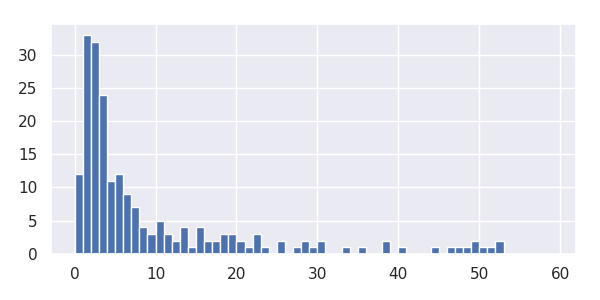

In [13]:
bootspread = np.zeros(microcolumns['counts'].shape[0])
for cell in range(microcolumns['counts'].shape[0]):
    points = np.squeeze(pos_boot[cell,:,:]).T
    distances = np.sqrt(np.sum((points - pos[cell,:])**2, axis=1))
    bootspread[cell] = np.percentile(distances, 80)
    
plt.figure(figsize=(6,3))
plt.hist(bootspread, bins=np.arange(0,60))
plt.tight_layout();

<IPython.core.display.Javascript object>


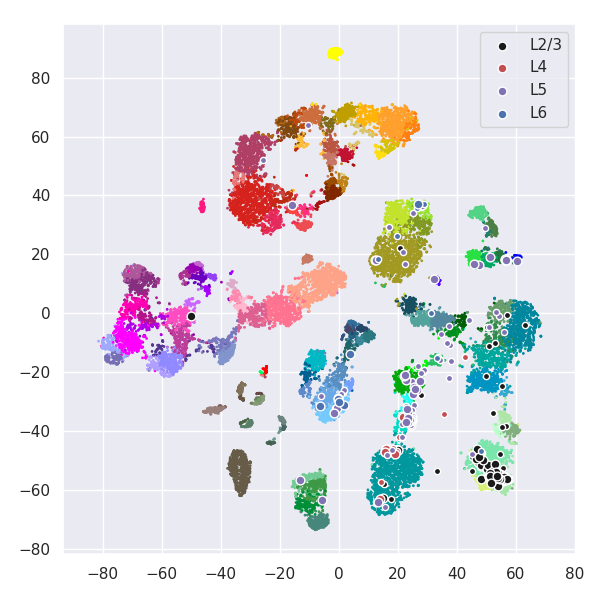

In [35]:
sns.set()
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=1, c=tasic2018['clusterColors'][tasic2018['clusters']])
plt.tight_layout()

ss = []
colors = ['k', 'r', 'm', 'b']
for i,layer in enumerate(np.unique(microcolumns['layers'])):
    ind = (microcolumns['layers'] == layer) & (bootspread > 5)
    plt.scatter(pos[ind,0], pos[ind,1], s=20, color=colors[i], edgecolors='w', linewidth=1)
    ind = (microcolumns['layers'] == layer) & (bootspread <= 5)
    s = plt.scatter(pos[ind,0], pos[ind,1], s=40, color=colors[i], edgecolors='w', linewidth=1)
    ss.append(s)

plt.legend(ss, ['L2/3', 'L4', 'L5', 'L6'])
plt.savefig('figures/tsne.png')

In [21]:
## Export for Cathryn

d = {'cellID': microcolumns['cells'],
     'tSNE1': pos[:,0],
     'tSNE2': pos[:,1],
     'uncertainty': bootspread}
df = pd.DataFrame(d)
df.to_csv('export/microcolumn-preprocessed-projection.txt', header=None, index=None, sep='\t')
df

,cellID,tSNE1,tSNE2,uncertainty
0,170406_p1_a2,16.613917,-46.747371,1.168786
1,170406_p1_a1,48.157627,-51.752802,4.717868
2,170406_p1_a3,42.799213,-14.867355,9.977390
3,170406_p1_a4,56.521720,18.004309,0.291398
4,170406_p1_a5,49.735992,29.039598,6.838253
5,170406_p1_a6,26.503083,-26.039425,3.973461
6,170406_p1_a10,37.465812,-21.925156,20.084901
7,170406_p1_a12,-0.518130,-32.192016,2.875834
8,170406_p1_a8,24.749698,-36.142482,1.125744
9,170406_p1_a11,28.335007,-19.882900,11.156081


# Cluster assignments

In [17]:
ass, C = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                microcolumns['counts'], microcolumns['genes'], 
                tasic2018['clusters'], returnCmeans=True)

df = pd.DataFrame(ass.astype(int))
df.index = microcolumns['cells']
df.columns = ['Cluster id']
df['Cluster name'] = tasic2018['clusterNames'][ass.astype(int)]
df['Correlation'] = np.max(C, axis=1)
df.to_csv('export/microcolumn-preprocessed-classification.txt', sep='\t', float_format='%.3f')
df

Using a common set of 1458 genes.


,Cluster id,Cluster name,Correlation
170406_p1_a2,66,L4 IT VISp Rspo1,0.867156
170406_p1_a1,60,L2/3 IT VISp Rrad,0.666428
170406_p1_a3,71,L5 IT VISp Col27a1,0.852640
170406_p1_a4,89,L5 PT VISp Lgr5,0.760307
170406_p1_a5,93,L5 PT ALM Slco2a1,0.801624
170406_p1_a6,69,L5 IT VISp Batf3,0.868743
170406_p1_a10,67,L5 IT VISp Hsd11b1 Endou,0.743342
170406_p1_a12,104,L6 CT VISp Ctxn3 Brinp3,0.769889
170406_p1_a8,67,L5 IT VISp Hsd11b1 Endou,0.849240
170406_p1_a11,70,L5 IT VISp Col6a1 Fezf2,0.719702


In [18]:
for r in ['V1', 'SS1']:
    x = df['Correlation'][microcolumns['regions']==r].values
    print(r+': {:.2f}+-{:.2f}'.format(x.mean(), x.std()))

from scipy.stats import ttest_ind
ttest_ind(df['Correlation'][microcolumns['regions']=='V1'].values, 
          df['Correlation'][microcolumns['regions']=='SS1'].values, equal_var=False).pvalue

V1: 0.78+-0.07
SS1: 0.78+-0.08


0.7609891595202936

In [19]:
ass, assboot = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                microcolumns['counts'], microcolumns['genes'], 
                tasic2018['clusters'], tasic2018['clusterNames'], microcolumns['cells'],
                bootstrap = True, nrep = 100, seed = 42, verbose = True, until=.95)

Using a common set of 1458 genes.
.................................................................................................... done
170406_p1_a2: L4 IT VISp Rspo1 (100.0%)
170406_p1_a1: L2/3 IT VISp Rrad (52.0%), L4 IT VISp Rspo1 (31.0%), L5 IT VISp Hsd11b1 Endou (12.0%)
170406_p1_a3: L5 IT VISp Col27a1 (51.0%), L4 IT VISp Rspo1 (21.0%), L5 IT VISp Col6a1 Fezf2 (11.0%), L5 IT ALM Cbln4 Fezf2 (9.0%), L5 IT VISp Hsd11b1 Endou (8.0%)
170406_p1_a4: L5 PT VISp Lgr5 (100.0%)
170406_p1_a5: L5 PT ALM Slco2a1 (47.0%), L5 PT VISp Lgr5 (32.0%), L5 PT ALM Npsr1 (11.0%), L5 PT VISp Krt80 (9.0%)
170406_p1_a6: L5 IT VISp Batf3 (96.0%)
170406_p1_a10: L5 IT VISp Hsd11b1 Endou (94.0%), L4 IT VISp Rspo1 (5.0%)
170406_p1_a12: L6 CT VISp Ctxn3 Brinp3 (68.0%), L6 CT VISp Ctxn3 Sla (32.0%)
170406_p1_a8: L5 IT VISp Hsd11b1 Endou (84.0%), L4 IT VISp Rspo1 (16.0%)
170406_p1_a11: L5 IT VISp Col6a1 Fezf2 (61.0%), L5 IT VISp Hsd11b1 Endou (31.0%), L4 IT VISp Rspo1 (5.0%)
170406_p1_a7: L5 IT VISp Hsd11b1 En

170406_p2_c9: L5 PT VISp Krt80 (94.0%), L5 PT VISp Lgr5 (6.0%)
170406_p2_c12: L4 IT VISp Rspo1 (88.0%), L5 IT VISp Hsd11b1 Endou (12.0%)
170406_p2_d2: L5 IT VISp Col6a1 Fezf2 (70.0%), L5 IT VISp Batf3 (19.0%), L5 IT VISp Hsd11b1 Endou (9.0%)
170406_p2_d1: L4 IT VISp Rspo1 (100.0%)
170406_p2_d3: L5 IT VISp Col27a1 (100.0%)
170406_p2_d4: L6 IT VISp Col18a1 (88.0%), L6 IT VISp Col23a1 Adamts2 (8.0%)
170406_p2_d5: L5 IT VISp Col27a1 (64.0%), L4 IT VISp Rspo1 (20.0%), L5 IT VISp Col6a1 Fezf2 (14.0%)
170406_p2_d7: L6 IT VISp Col18a1 (100.0%)
170406_p2_d6: L6 IT VISp Col18a1 (97.0%)
170406_p2_d9: L6 IT VISp Col18a1 (97.0%)
170406_p2_d11: L6 IT VISp Col18a1 (100.0%)
170406_p2_d10: L6 IT VISp Col18a1 (54.0%), L6 IT VISp Penk Fst (39.0%), L6 IT VISp Col23a1 Adamts2 (5.0%)
170406_p2_d12: L6 CT VISp Ctxn3 Brinp3 (46.0%), L6 CT VISp Gpr139 (35.0%), L6 CT VISp Krt80 Sla (12.0%), L6 CT ALM Nxph2 Sla (5.0%)
170406_p2_e1: L4 IT VISp Rspo1 (100.0%)
170406_p2_e2: L5 IT VISp Batf3 (97.0%)
170406_p2_e4: L5

In [20]:
df = pd.DataFrame(assboot)
df.index = microcolumns['cells']
df.columns = tasic2018['clusterNames']
df.to_csv('export/microcolumn-preprocessed-classification-matrix.txt', sep='\t')
df

,Lamp5 Krt73,Lamp5 Fam19a1 Pax6,Lamp5 Fam19a1 Tmem182,Lamp5 Ntn1 Npy2r,Lamp5 Plch2 Dock5,Lamp5 Lsp1,Lamp5 Lhx6,Sncg Slc17a8,Sncg Vip Nptx2,Sncg Gpr50,...,VLMC Osr1 Cd74,VLMC Osr1 Mc5r,VLMC Spp1 Hs3st6,VLMC Spp1 Col15a1,Peri Kcnj8,SMC Acta2,Endo Ctla2a,Endo Cytl1,PVM Mrc1,Microglia Siglech
170406_p1_a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170406_p1_a1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170406_p1_a3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170406_p1_a4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170406_p1_a5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170406_p1_a6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170406_p1_a10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170406_p1_a12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170406_p1_a8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170406_p1_a11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Oligo cell

<IPython.core.display.Javascript object>


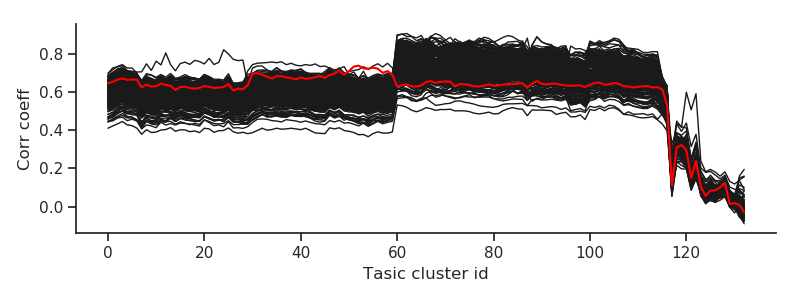

In [43]:
sns.set_style('ticks')
plt.figure(figsize=(8,3))
plt.plot(C.T, color='k', linewidth=1)
plt.plot(C[microcolumns['cells']=='170406_p2_a8',:].squeeze(), color='red')
plt.xlabel('Tasic cluster id')
plt.ylabel('Corr coeff')
sns.despine()
plt.tight_layout()
plt.savefig('figures/170406_p2_a8.png')

<IPython.core.display.Javascript object>


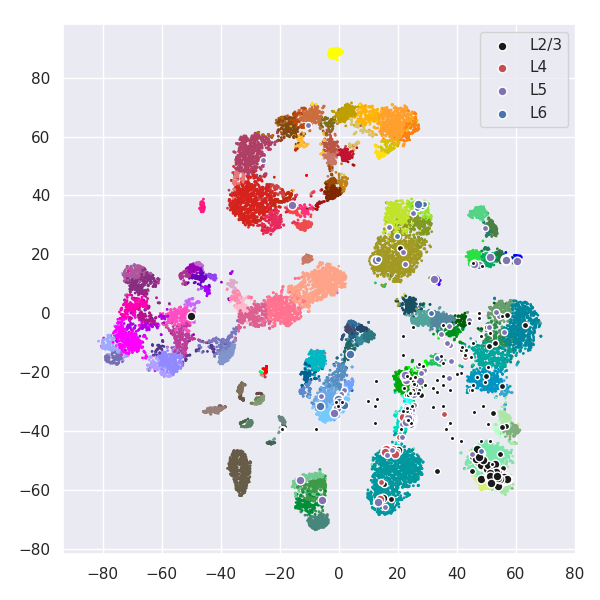

In [30]:
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=1, c=tasic2018['clusterColors'][tasic2018['clusters']])
plt.tight_layout()

ss = []
colors = ['k', 'r', 'm', 'b']
for i,layer in enumerate(np.unique(microcolumns['layers'])):
    ind = (microcolumns['layers'] == layer) & (bootspread > 5)
    plt.scatter(pos[ind,0], pos[ind,1], s=20, color=colors[i], edgecolors='w', linewidth=1)
    ind = (microcolumns['layers'] == layer) & (bootspread <= 5)
    s = plt.scatter(pos[ind,0], pos[ind,1], s=40, color=colors[i], edgecolors='w', linewidth=1)
    ss.append(s)

plt.legend(ss, ['L2/3', 'L4', 'L5', 'L6'])


plt.scatter(pos_boot[12,0,:].squeeze(), pos_boot[12,1,:].squeeze(), s=10, color='k', edgecolors='w', linewidth=1)